# 6.12 Assignment: Quantum Walks

## Instructions
### Final assignment

Follow the example from [Bootcamp 4](https://www.youtube.com/watch?v=kHJLwfDUSWI&list=PL_wGNAk5B0pXq98BJBKsbNH2Qjp1lk8dG&index=31&ab_channel=WOMANIUM) for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:
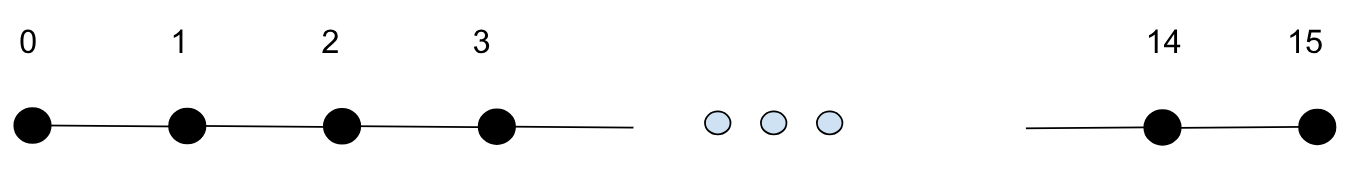

Create a well-detailed Python Jupyter notebook that explains your algorithm, including the code parts covered in class, and pictures/figures where relevant.

1.   Utilize the Python code from class: [quantum_walk_circle_example.py](https://github.com/Classiq/classiq-library/blob/main/community/womanium/assignments/quantum_walk_circle_example.py). It can be found directly also in the Classiq Git Library in the [community/womanium/assignments](https://github.com/Classiq/classiq-library/tree/main/community/womanium/assignments)folder.
2.   Feel free to extend the example beyond the requirements here and what was covered in class.





## Assignment solution

The implementation of the Quantum Walk opertor for the graph of the assignment starts from the Python code quantum_walk_circle_example.py.

I adapted the code for our graph and also made some improvements to generalize a little the code.

I also found a couple of minor errors that I corrected in the code. See the note at the end of the section *Building the $C$ operator*.

In the followin code cell, we set the import instructions and some parameters of the regarding our graph, namely: `n_vert` the number of vertices,  `size`the number of the qubits needed to represent the states of the vertices, and `E` the list of edges (pairs of indices of connected vertices).

Our graph has $16$ vertices thus `size` is euqual to $\lfloor \log_2(16) \rfloor  =4$.

In [1]:
from classiq import *

size = 4
n_vert = 16
E = []
for i in range(n_vert-1):
    E.append([i,i+1])

### Quantum Walk operator

Here, I will follow the namings and notation of Childs in his lecture notes and also showed by Eden in class.

The Quantum Walk operator is given by the product $SC$ of two operators, $C$ and $S$. This operator represents the evolution of the state in one time step.

In the follwing sections, I will give the defintions of the two operators and the implementations for the graph given by the assignment description.

### Building the $C$ operator

The $C$ operator is defined by
$$
C := \sum_{j \in V} |j\rangle \langle j | \otimes \left( 2 |\partial_j \rangle \langle \partial_j| - I   \right)
\tag{1}
$$
where
$$
|\partial_j \rangle := \frac{1}{\sqrt{\textrm{deg}(j)}}\sum_{k:(j,k) \in E} |k\rangle \ .
$$



Let's define $U_j$ an operator that prepare the state $|\partial_j \rangle$ from the initial state $|0 \rangle$:
$$ U_j |0 \rangle = |\partial_j \rangle  $$
then we can decompose the operator $\left( 2 |\partial_j \rangle \langle \partial_j| - I \right)$ as
$$
2 |\partial_j \rangle \langle \partial_j| - I  =
 U_j \left( 2 |0 \rangle \langle 0| - I \right) U_j^\dagger
$$

Indeed, the operator $\left( 2 |\partial_j \rangle \langle \partial_j| - I \right)$ is called by Childs as the Grover's diffusion operator, where $U_j$, in the Grover's algorithm, is the the Hadamard transform operator.

The operation peformed by $\left( 2 |0 \rangle \langle 0| - I \right)$ is sometimes called conditional phase shift. It changes the sign (i.e changes the pahse) of all computational states $|x \rangle$ except the state $|0 \rangle$, i.e. $|x \rangle → -(-1)^{δ_{x,0}} |x \rangle $, or, following the Classiq notation, $|x \rangle → (-1)^{x \neq 0 } |x \rangle $. Latter expression is a shorthand of $|x \rangle → (-1)^{f(x)} |x \rangle$ with $f(x)$ defined as $f(x)= \begin{cases} & 1 & x \neq 0 \\ & 0 & x = 0 \end{cases} $.

This is a phase kickback operation, so we can use phase kickback method to implement the conditional phase shift operator $\left( 2 |0 \rangle \langle 0| - I \right)$.

So we have to use an auxiliary qubit to store the state $|- \rangle$ for the phase kickback operation.

Thus we define the function `prepare_minus` to initialiase a qubit in the state $|- \rangle$:

In [2]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

Then we define the functions `diffuzer_oracle` and `zero_diffuzer` that implement the conditional phase shift operator $\left( 2 |0 \rangle \langle 0| - I \right)$.

The first function,`diffuzer_oracle`,  implement the Oracle operator $U_f$ of the phase kickeback, i.e. $U_f |x\rangle|y\rangle = |x\rangle|y \oplus f(x) >$, where $f(x)$ is the function defined above (i.e. it represents the condition $x \neq 0$).

Then the second fucntion `zero_diffuzer` implements the whole action of  $\left( 2 |0 \rangle \langle 0| - I \right)$ using the function `prepare_minus` in the `compute` block of `within_apply` to prepare the state $|-\rangle$ and uncompute it after the action of the $U_f$, and function `diffuzer_oracle` (for $U_f$) in the `action` block.

To be clearer, let's call $V$ the operator, corresponding to the the function `prepare_minus` (that prepares the state $|-\rangle$):
$$
V  | 0 \rangle = | - \rangle \ .
$$
Then the function
```
within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)
```
performs the operation
$$
(I \otimes V^\dagger ) U_f (I \otimes V )| x \rangle | 0 \rangle =
\big( \left( 2 |0 \rangle \langle 0| - I \right) | x \rangle \big) \otimes | 0 \rangle  
$$


**NOTE**: I have found a couple of errors in orginal code in the file `quantum_walk_circle_example.py`, that I corrected here, in the follwing cell. The first is in `zero_diffuzer` function: in the `action` argument the lambda function was set to `diffuzer_oracle`, without the arguments `(aux,x)`. I added the arguments, so the lambda became `diffuzer_oracle(aux,x)`, however then when I run the command `synthesize(qmod)` it gives errors about the `aux` variable (saying something about that it is inout but it is found not initialized). Then I noticed in the function `diffuzer_oracle` the arugmennt `aux` was declared as `Output[QBit]`, although it should be also in input, since in it is initialized in `zero_diffuzer` before calling `diffuzer_oracle` so this is the second error. So I removed`Output[ ]`, and the synthesis worked.

In [3]:
@qfunc
def diffuzer_oracle(aux: QNum,x:QNum): # <-- second error was here
  aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle(aux,x)) # <-- first error was here

In the following we'll build ine the function `C_operator` that implement the operator $C$.

The function `C_operator` contains a loop of iterations, that is the loop over the vertices of the graph, i.e. over on the index $j$ of the sum in the defintion of $C$, Eq. $(1)$.

The `C_iteration` contains the part of `C_operator` that is itereated, i.e. it implements the single element of the sum in the $C$ operator, $|j\rangle \langle j | \otimes \left( 2 |\partial_j \rangle \langle \partial_j| - I   \right)$. This operation means that the oprator $\left( 2 |\partial_j \rangle \langle \partial_j| - I   \right)$ is condtioned by the state of the first register to be in the vertex $j$, so by being the state $|j\rangle$.

Thus in the `C_iteration` we apply this controlled operation, i.e. the Grover's diffussion operator $\left( 2 |\partial_j \rangle \langle \partial_j| - I   \right)$ controlled by the state  $|j\rangle$.

In the following cell, I have modified the original `W_iteration` function (here renamed `C_iteration`), by taking out of the fucntion, the part that is graph dpendent.

The latter is the preparation of state $\partial_j$ that here I call state "partial", from the symbol $\partial$ used by A.Childs in his Lecture Notes, so I'll call the function that performs this preparation `prepare_state_partial_j`.
This function it is formed by two part. The first, that I separated in the function `compute_prob_state_partial_j`, computes the probabilities of the computational states needed for the preparation of the state partial. The second part is the builtin function `inplace_prepare_state` for the preparation of the state partial using the probabilities computed in the first part.

Note: I coded 2 versions of the function `compute_prob_state_partial_j`: 1) one called `compute_prob_state_partial_j` is applicable to any graph, providing the list `E` of the edges; 2) the other called `compute_prob_state_partial_j_line` is applicable to any graph that is a line of `n_vert` vertices, with its ends not connected. In the function `prepare_state_partial_j` I used the first one.

Furthermore, for more clearness of the code, I have taken out of the function, also the controlled function, i.e. the function that implements the operator Grover's diffusion operator $\left( 2 |\partial_j \rangle \langle \partial_j| - I \right)$,  and I called this function `grover_diffuser`.

In [4]:
# NOTE: this function is applicable to any graph providing the list E of edges
def compute_prob_state_partial_j(i: int):
    prob = [0] * n_vert
    deg_i=0
    for edge in E:
        if (edge[0] == i):
            deg_i += 1
            k = edge[1]
            prob[k] = 1
        elif (edge[1] == i):
            deg_i += 1
            k = edge[0]
            prob[k] = 1
    prob = [prob[k] / deg_i for k in range(n_vert)]
    print(f'Partial state {i}: prob vec ={prob}')
    return prob

# NOTE: this function is applicable to any graph that is a line of n_vert noeds, with its ends not connected
def compute_prob_state_partial_j_line(i: int):
    prob = [0] * n_vert
    if i == 0:
        prob[1] = 1
    elif i == (n_vert-1):
        prob[n_vert-2] = 1
    else:
        prob[i+1] = 0.5
        prob[i-1] = 0.5
    print(f'Partial state {i}: prob vec ={prob}')
    return prob

def prepare_state_partial_j(i: int, adjacent_vertices: QNum):
    prob = compute_prob_state_partial_j(i)
    inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices)

def grover_diffuser(i: int, vertices: QNum, adjacent_vertices: QNum):
    within_apply(
        compute= lambda: prepare_state_partial_j(i,adjacent_vertices),
        action= lambda: zero_diffuzer(adjacent_vertices))

def C_iteration(i: int, vertices: QNum, adjacent_vertices:QNum):
    control(ctrl= vertices==i,
            operand= lambda: grover_diffuser(i,vertices,adjacent_vertices))

Here we define the `C_operator` function, that simply iterates over all vertices and at each iteration call the function `C_iteration`

In [5]:
@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)

### Building the operator $S$.

The  operator $S$  is defined as
$$
S:=\sum_{(j,k)\in E} | j, k \rangle \langle k,j| \ .
$$

This operator for each pair $(j,k)$ of connected vertices ($(j,k)\in E$) swap the states of the two vertices, i.e. the state $|j\rangle$ of the first register goes to the second one and vice versa, the state $|k\rangle$ of the second register go to the first one.

In the following cells we define the functions for building the operator $S$.

The first function is `edge_oracle` that is graph dependent. So we have to mofify the original funciton coded for the simple circle 4-vertex graph, to adapt it to our graph consituted by 16 vertices in line.

This functions tells wether a pair of vertices belong to an edge, i.e. if they are connected. If they are connected the function returns a quantum variable `res`, made only by one qubit, with the value $1$, otherwise $0$.

In our graph each vertex $j$ is connected to the previous vertex, $j-1$, and/or to the next one, $j+1$ (the first vertex, $0$, is connected only to the next one, the last vertex only to the previous one, and all the other vertices are connected ot both (previus and next)).

Therefore the differences between the indices of two connected vertices is always 1 or -1. Thus we implement this condition in the function `edge_oracle`.

Note: this oracle function is applicable to any graph in line with its ends not connected.

In [6]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((vertices-adjacent_vertices) == 1) | ((vertices-adjacent_vertices) == -1)

In the following cell we define function `bitwise_swap` that implements the swap operation $| j, k \rangle \langle k,j|$.
This is performed by applying a SWAP operation, between 2 qubits belongig to the 2 registers, bitwise, for all qbuits in the registers.

In [7]:
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
         iteration= lambda i: SWAP(x[i],y[i]))

In the folkowing cell, the `S_operator` function implements the operator $S$. It performs the swap only if the pair of vertices $(j, k)$ are connected.

Therefore, in the function we condition (with the `control` function) the swap operation on the result `res` of the function `edge_oracle` to be $1$, i.e. only if the pair of vertices are connected, that is what we want.

In [8]:
@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

### Putting together in the main function

Finally we put in the `main` function the 2 operators togheter, forming the Quantum Walk operator $SC$ for one time step. Before applying $SC$ we prepare the state of the graph in equal superpostion of all states of the vertices. So we applly the Hadamard Transform and then the $SC$ operator.

In [9]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)

Partial state 0: prob vec =[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 1: prob vec =[0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 2: prob vec =[0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 3: prob vec =[0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 4: prob vec =[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 5: prob vec =[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 6: prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 7: prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 8: prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Partial state 9: prob vec =[

In [10]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/ea4d4de5-7684-4c11-8e28-d18eada484af?version=0.43.3


The circuit we obtain (without specifiying any optimization settings) has width $37$ qubits and a depth of $6279$ gates for the non-transpiled circuit and $4173$ gates for the transpiled circuit. In the pictures below I show the high level diagram of the circuit and parts of the  expansion of `C_operator` and `S_operator`.

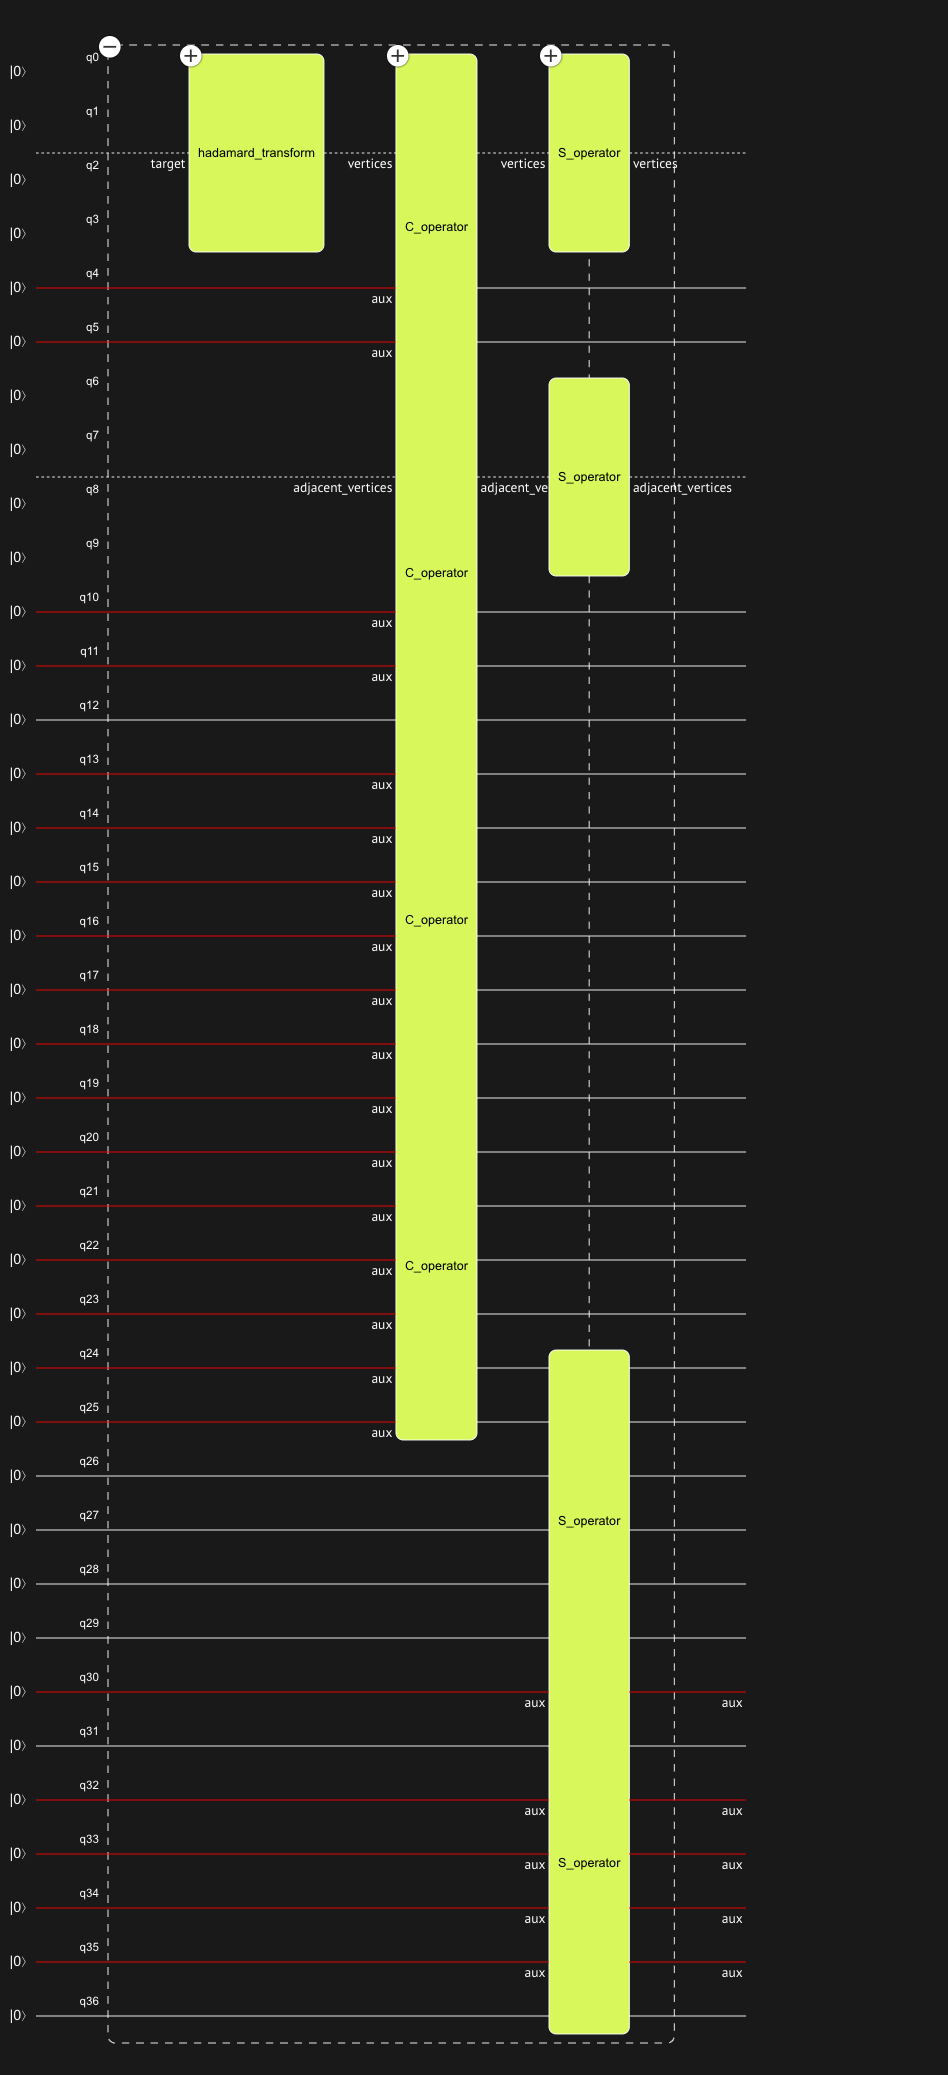

Expansion of `C_operator` (partial because it is very wide):

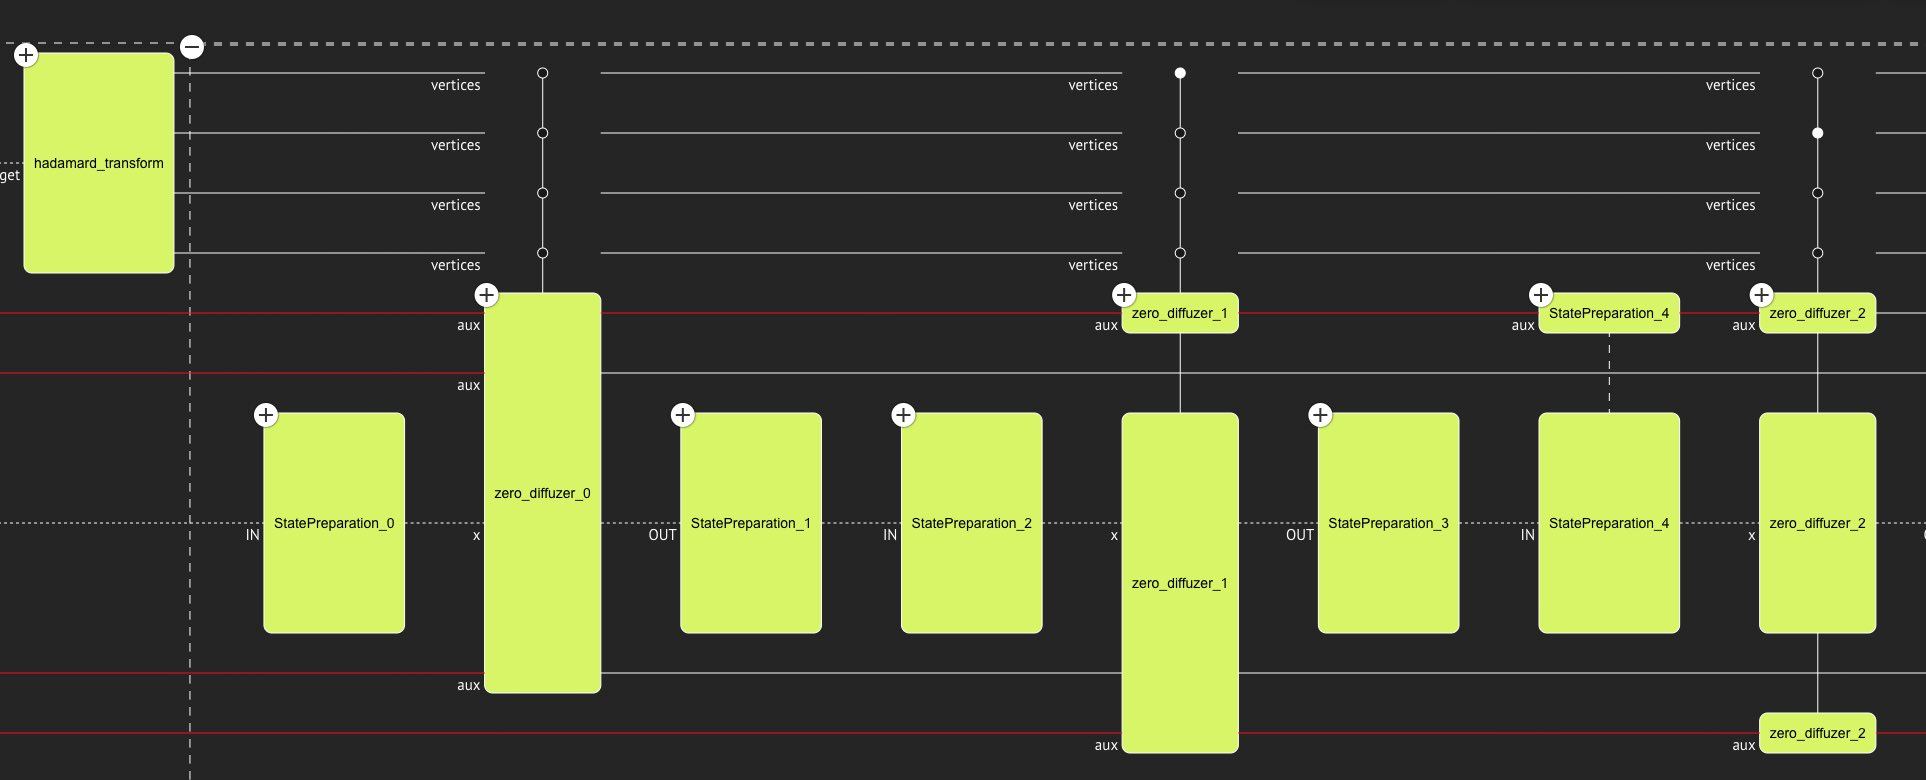

The diagram of the circuit with `S_operator` expanded:
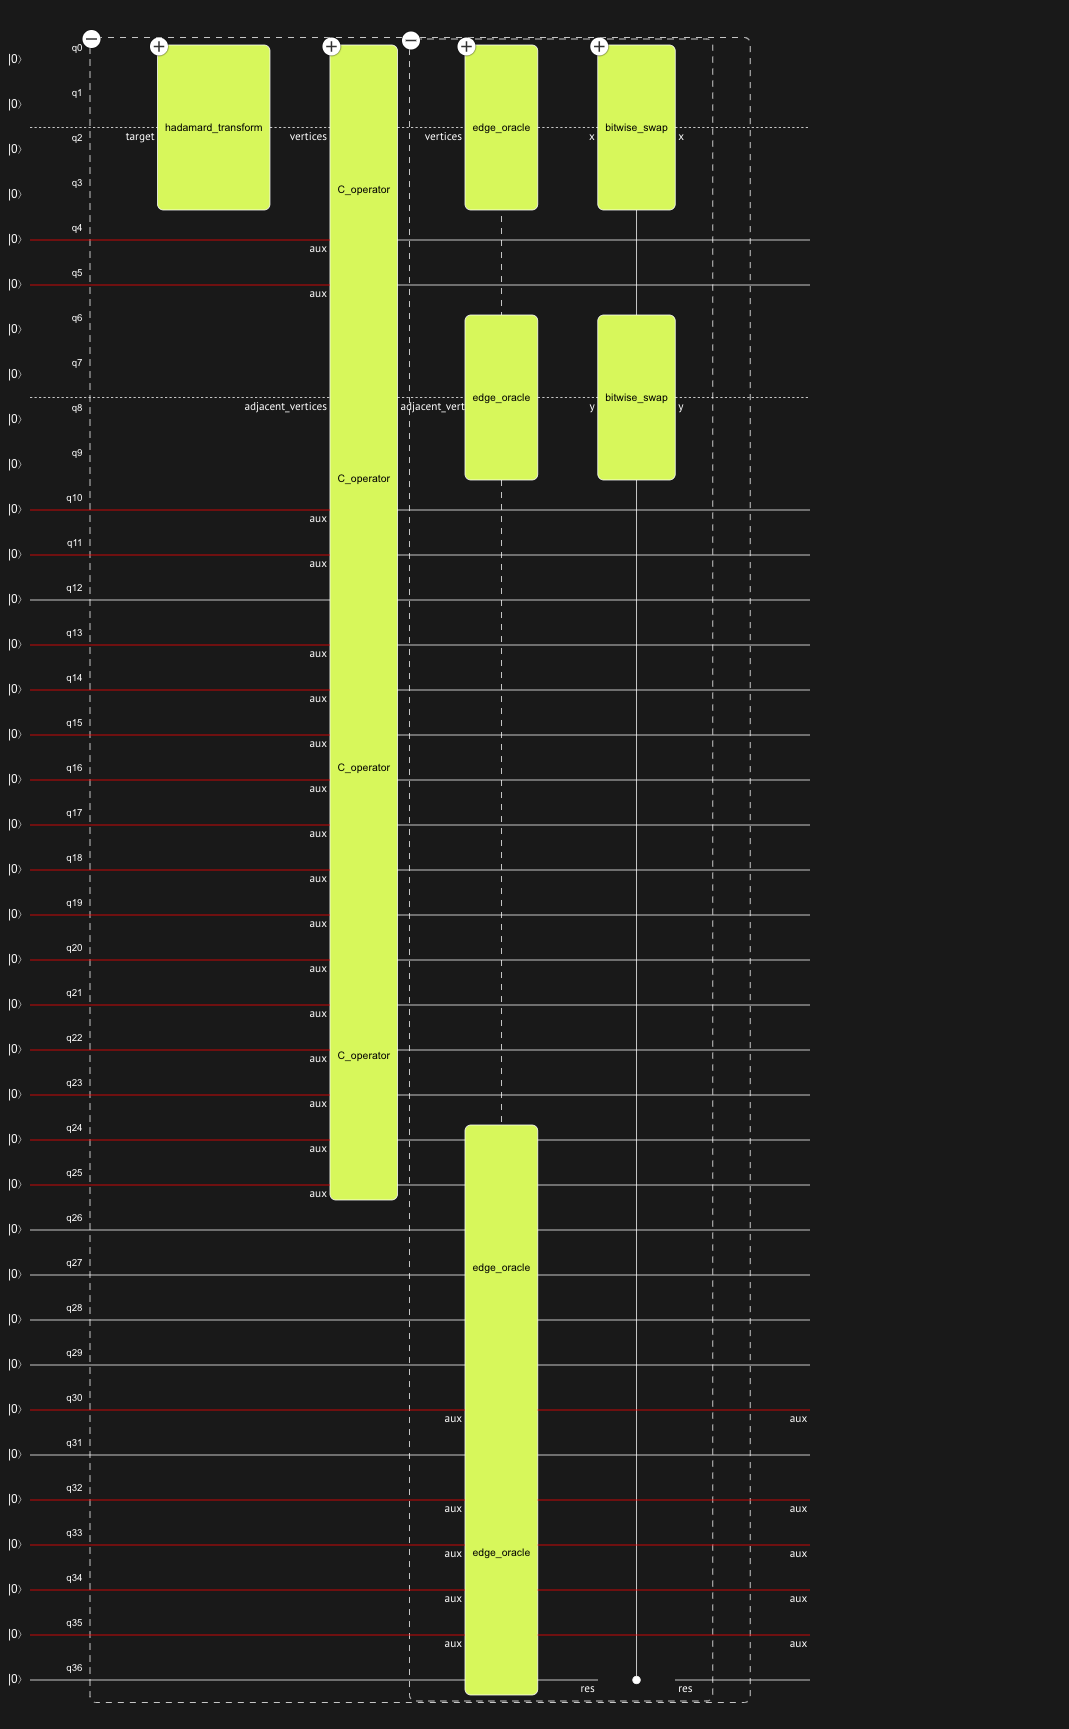